# `EmissionModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionModel` model. `EmissionModel` models 21-cm emission spectra like those obtained from typical ON - OFF observations.

In [ ]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"emission"`.

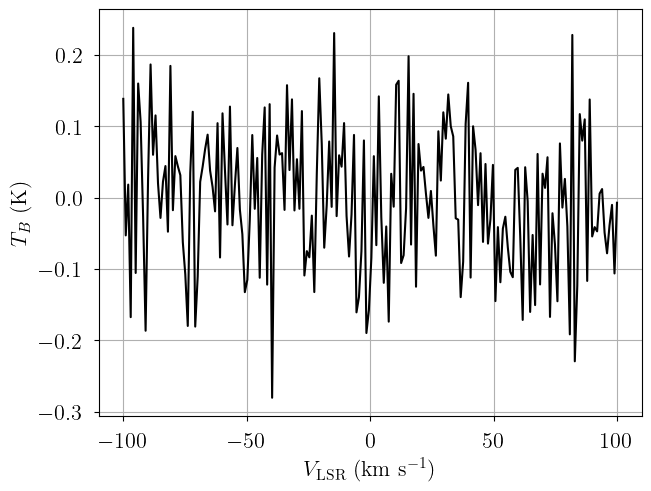

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-100.0, 100.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.1 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms * np.random.randn(len(velo_axis))

dummy_data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
ax.set_xlabel(dummy_data["emission"].xlabel)
_ = ax.set_ylabel(dummy_data["emission"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 20.5]),
    "log10_depth": np.array([1.5, 0.5, 2.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.5]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.1,
    "larson_power": 0.3,
    "rms_emission": rms,
    "baseline_emission_norm": np.array([0.0]),
}
emission = model.model["emission"].eval(sim_params)
data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

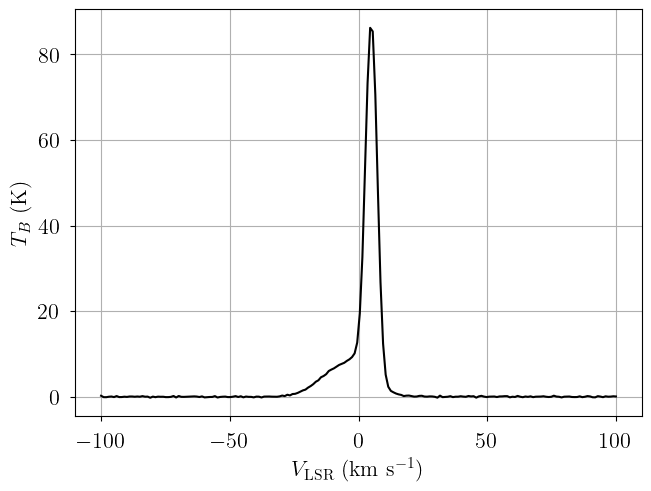

In [5]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["emission"].spectral, data["emission"].brightness, "k-")
ax.set_xlabel(data["emission"].xlabel)
_ = ax.set_ylabel(data["emission"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `EmissionModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = EmissionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

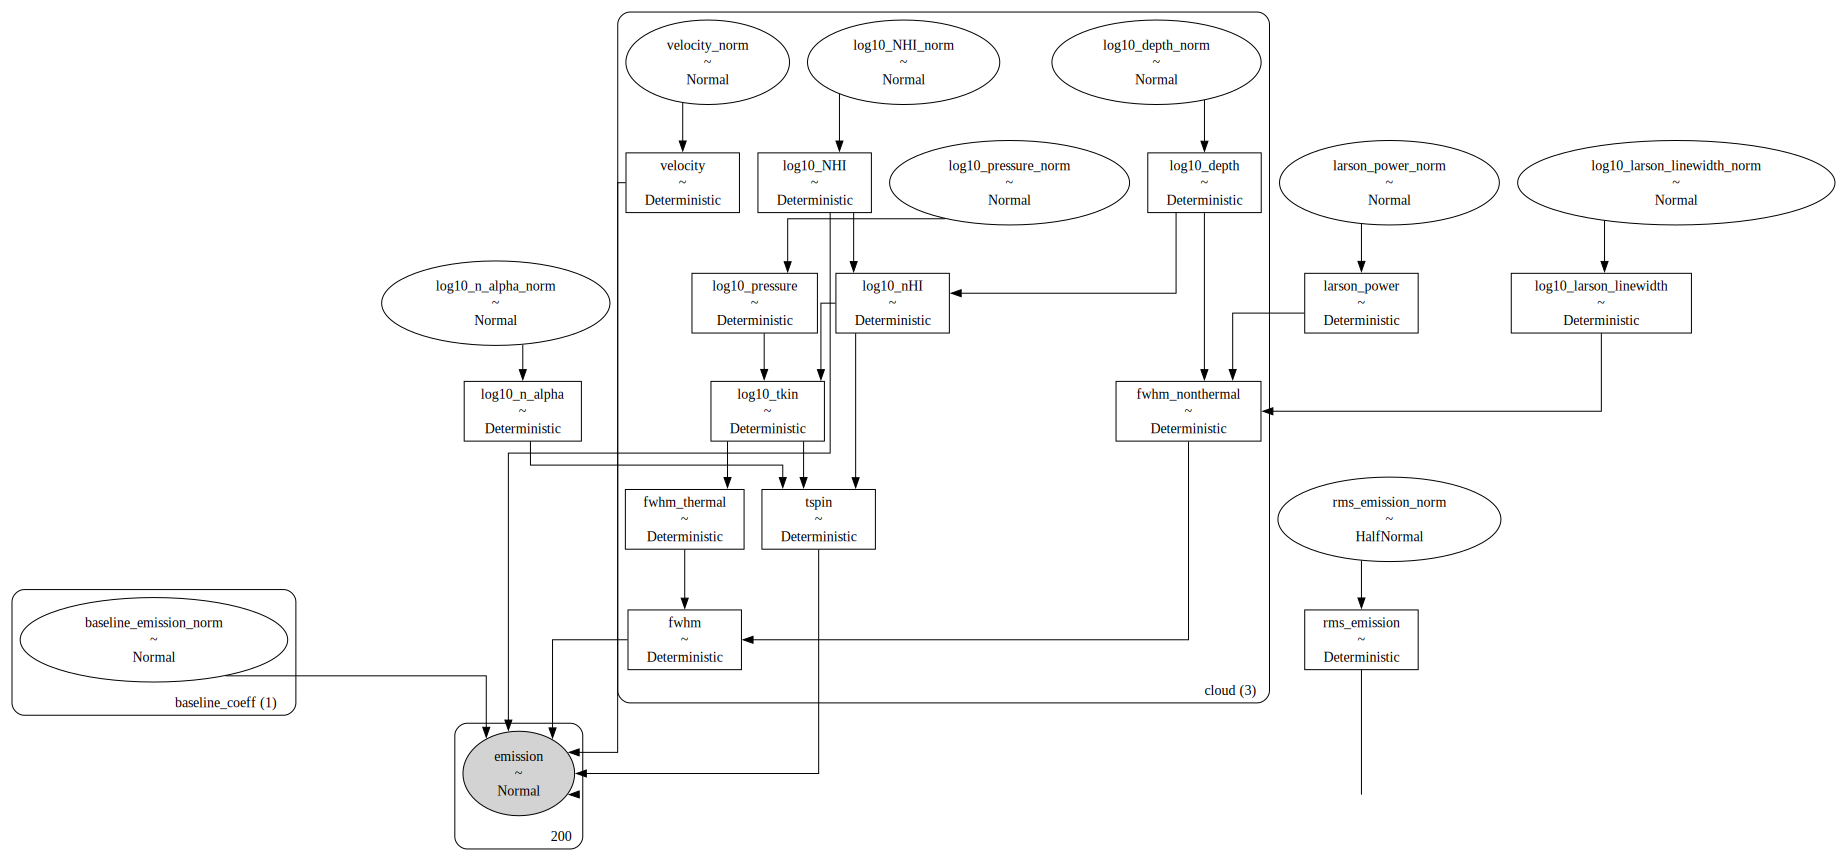

In [7]:
# Plot model graph
model.graph().render('emission_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
          rms_emission_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                  log10_nHI ~ Deterministic(f(log10_depth_norm, log10_NHI_norm))
                 log10_tkin ~ Deterministic(f(log10_pressure_

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_emission_norm, emission, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, rms_emission_norm, velocity_norm]


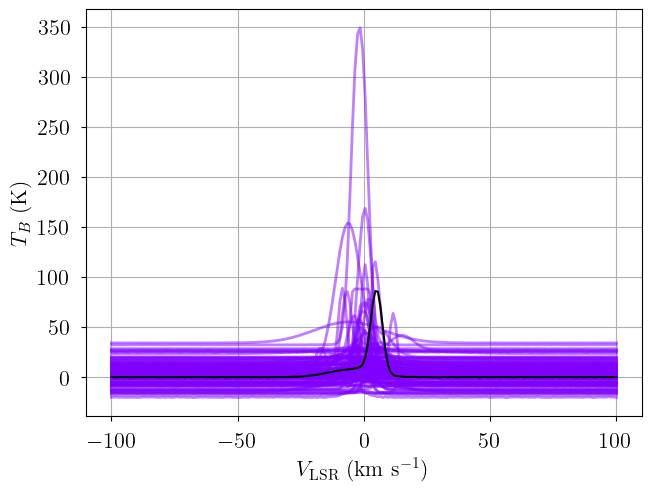

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6900
Interrupted at 6,899 [6%]: Average Loss = 93,593


Output()

Runtime: 0.48 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_emission_norm[0],-0.263,0.001,-0.265,-0.261,0.000,0.000,994.0,936.0,NaN
fwhm[0],20.891,0.202,20.501,21.267,0.006,0.004,1018.0,943.0,NaN
fwhm[1],6.169,0.050,6.080,6.263,0.002,0.001,1082.0,1025.0,NaN
fwhm[2],4.527,0.019,4.492,4.562,0.001,0.000,933.0,732.0,NaN
fwhm_nonthermal[0],8.598,0.063,8.478,8.711,0.002,0.001,1001.0,1017.0,NaN
fwhm_nonthermal[1],4.443,0.026,4.395,4.490,0.001,0.001,1198.0,978.0,NaN
fwhm_nonthermal[2],3.676,0.016,3.647,3.704,0.001,0.000,699.0,903.0,NaN
fwhm_thermal[0],19.040,0.208,18.642,19.442,0.006,0.005,1030.0,806.0,NaN
fwhm_thermal[1],4.279,0.058,4.175,4.384,0.002,0.001,1049.0,935.0,NaN
fwhm_thermal[2],2.641,0.019,2.607,2.676,0.001,0.000,1030.0,881.0,NaN


Sampling: [emission]


Output()

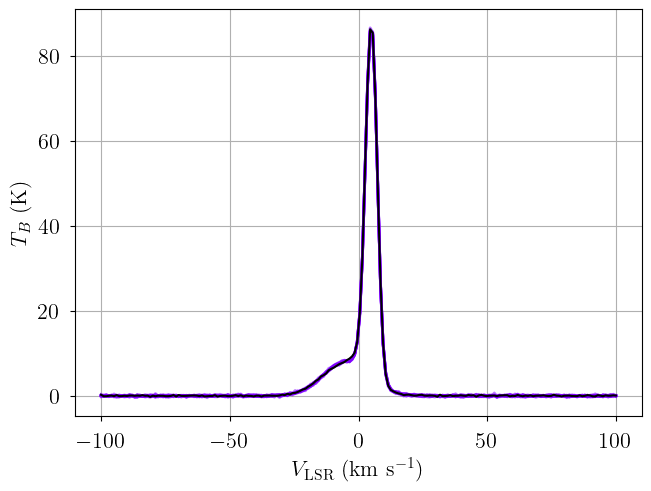

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC. We use the fast `nutpie` sampler.

In [14]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=4,  # number of independent chains
    cores=4,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6900
Interrupted at 6,899 [6%]: Average Loss = 93,593
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, rms_emission_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1335 seconds.


Adding log-likelihood to trace


Output()

There were 163 divergences in converged chains.
Runtime: 22.93 minutes


In [15]:
model.solve()

GMM converged to unique solution
2 of 4 chains appear converged.


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [16]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_emission_norm[0],-0.262,0.001,-0.263,-0.261,0.000,0.000,1790.0,1430.0,1.00
fwhm[0],21.300,0.151,20.998,21.580,0.006,0.004,747.0,819.0,1.00
fwhm[1],7.905,0.823,6.483,9.433,0.041,0.029,412.0,798.0,1.00
fwhm[2],5.042,0.029,4.987,5.094,0.001,0.001,741.0,1476.0,1.00
fwhm_nonthermal[0],11.812,6.300,3.193,21.186,0.401,0.288,221.0,265.0,1.00
fwhm_nonthermal[1],4.580,2.138,1.078,8.185,0.114,0.081,344.0,477.0,1.00
fwhm_nonthermal[2],3.454,0.094,3.284,3.623,0.003,0.002,1189.0,1542.0,1.00
fwhm_thermal[0],15.293,6.376,2.543,21.322,0.438,0.310,204.0,148.0,1.01
fwhm_thermal[1],5.826,1.916,2.068,8.693,0.113,0.080,283.0,314.0,1.00
fwhm_thermal[2],3.671,0.119,3.448,3.891,0.004,0.003,1147.0,1685.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [emission]


Output()

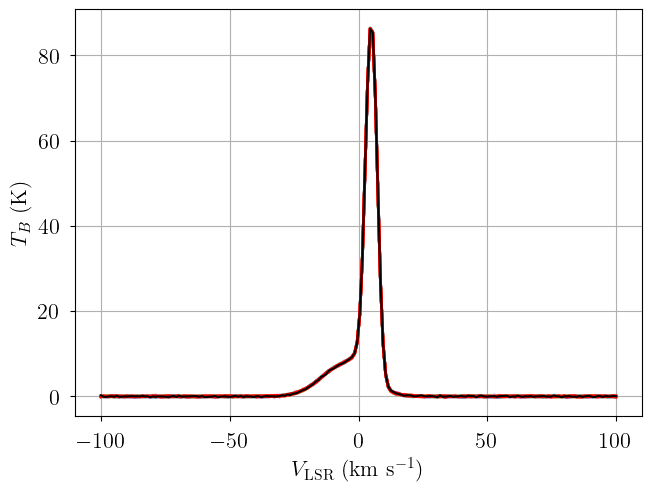

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

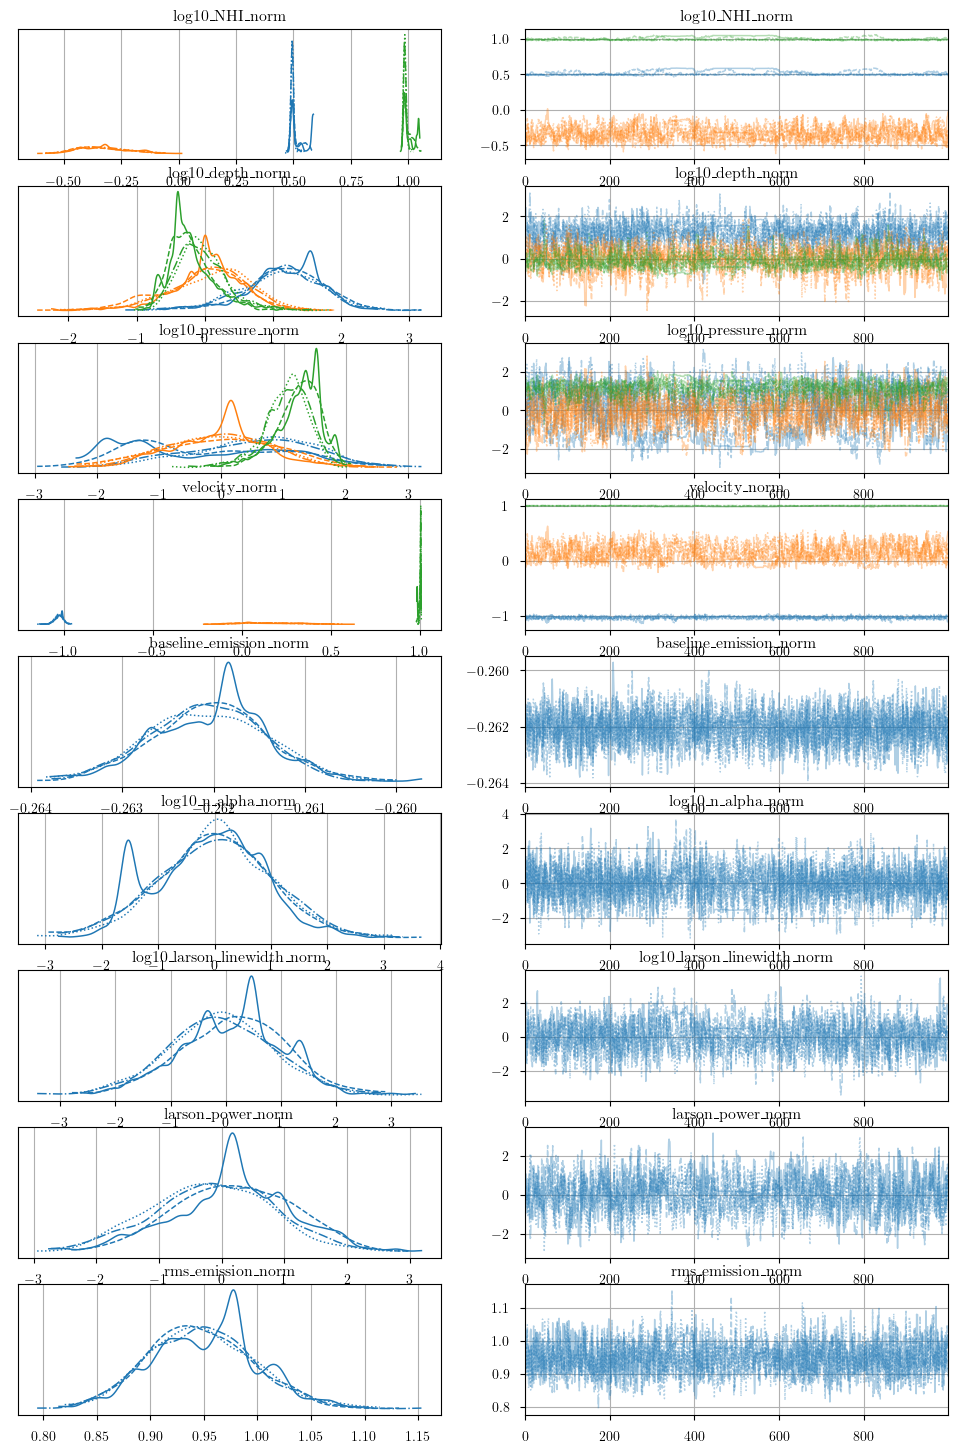

In [18]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

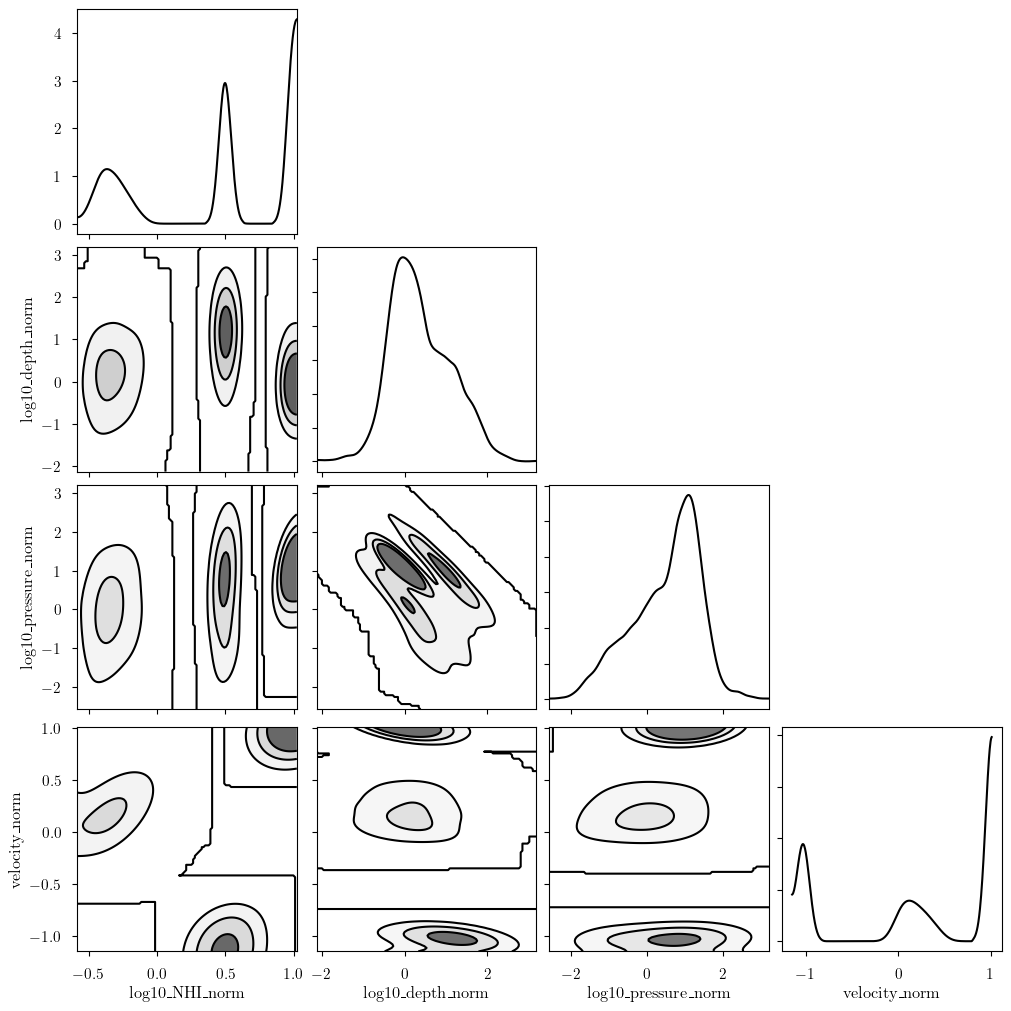

In [19]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

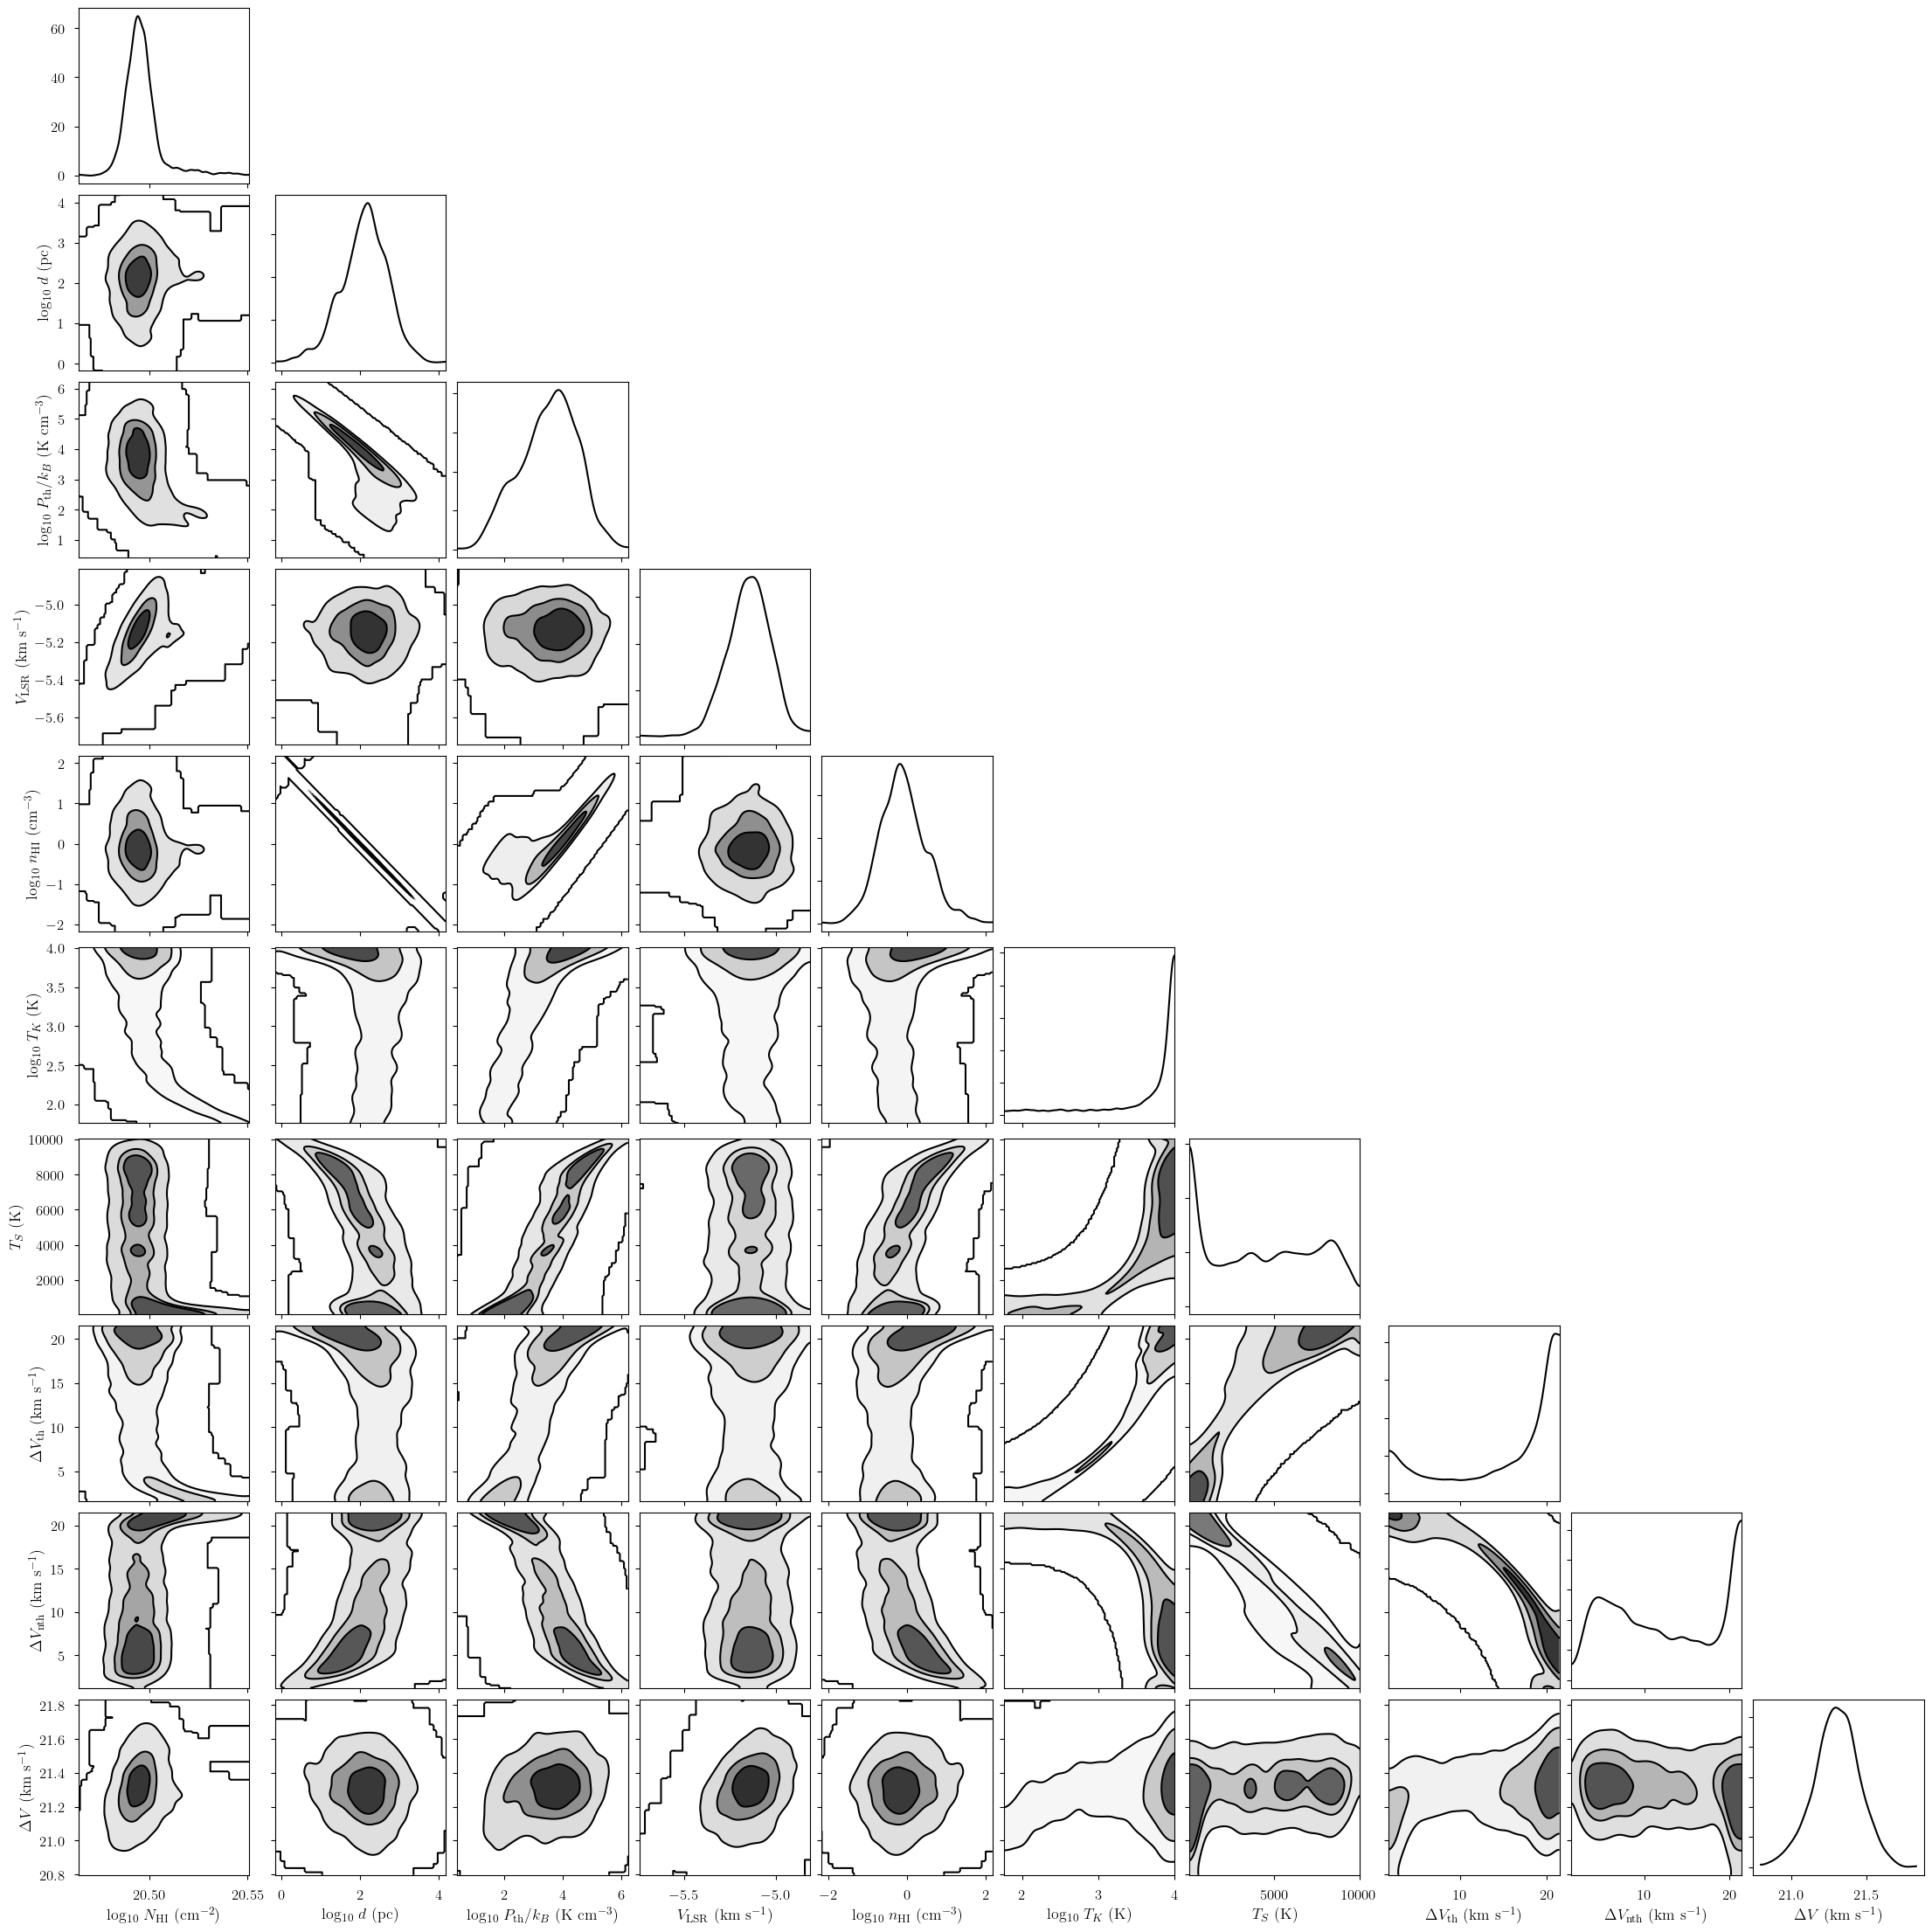

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -285.6255111741125


,mean,sd,hdi_16%,hdi_84%
baseline_emission_norm[0],-0.262,0.001,-0.263,-0.261
fwhm[0],21.300,0.151,21.169,21.457
fwhm[1],7.905,0.823,7.026,8.734
fwhm[2],5.042,0.029,5.020,5.074
fwhm_nonthermal[0],11.812,6.300,2.590,16.515
fwhm_nonthermal[1],4.580,2.138,1.583,6.244
fwhm_nonthermal[2],3.454,0.094,3.375,3.558
fwhm_thermal[0],15.293,6.376,14.024,21.375
fwhm_thermal[1],5.826,1.916,4.725,8.461
fwhm_thermal[2],3.671,0.119,3.551,3.785
